# 5) Color Words & Description Density

**Goal:** Count color terms and compare description density.

# Setup: Load Texts

This notebook needs **Crime And Punishment** and **The Brothers Karamazov** as input texts.

**How to provide the texts:**
1. Download books from Project Gutenberg (IDs 11 and 12) as txts. [go to https://www.gutenberg.org/ebooks/2554 and https://www.gutenberg.org/ebooks/28054]

2. Place two text files in the "data" folder with names:
   - `Crime-punishment.txt`  (Crime And Punishment)
   - `The-BrothersKaramazov.txt` (The Brothers Karamazov)





In [2]:
# Install matplotlib in this notebook environment if it's missing.
%pip install matplotlib

import re
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt

     ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
     - -------------------------------------- 0.4/8.1 MB 11.8 MB/s eta 0:00:01
     ------ --------------------------------- 1.3/8.1 MB 15.9 MB/s eta 0:00:01
     ---------- ----------------------------- 2.1/8.1 MB 16.4 MB/s eta 0:00:01
     ------------- -------------------------- 2.7/8.1 MB 17.3 MB/s eta 0:00:01
     ------------------ --------------------- 3.7/8.1 MB 18.0 MB/s eta 0:00:01
     --------------------- ------------------ 4.3/8.1 MB 17.0 MB/s eta 0:00:01
     ---------------------- ----------------- 4.6/8.1 MB 15.5 MB/s eta 0:00:01
     ------------------------- -------------- 5.1/8.1 MB 14.8 MB/s eta 0:00:01
     --------------------------- ------------ 5.5/8.1 MB 14.1 MB/s eta 0:00:01
     ----------------------------- ---------- 5.9/8.1 MB 13.6 MB/s eta 0:00:01
     ------------------------------- -------- 6.3/8.1 MB 13.0 MB/s eta 0:00:01
     --------------------------------- ------ 6.8/8.1 MB 12.

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:

def load_texts(local_crime: str = '../data/Crime-punishment.txt',
               local_brothers: str = '../data/The-BrothersKaramazov.txt'):
    """Load Crime and Punishment and The Brothers Karamazov texts from disk.

    Parameters
    ----------
    local_crime : str
        Path to Crime and Punishment text file. Defaults to '../data/Crime-punishment.txt'.
    local_brothers : str
        Path to The Brothers Karamazov text file. Defaults to '../data/The-BrothersKaramazov.txt'.

    Returns
    -------
    tuple[str, str]
        (crime_text, brothers_text).

    Raises
    ------
    FileNotFoundError
        If either file is missing.

    Extra Notes
    -----------
    - Using UTF-8 with `errors='ignore'` avoids codec exceptions on
      older Project Gutenberg dumps or inconsistent encodings.
    """
    p1, p2 = Path(local_crime), Path(local_brothers)

    # Fail fast with a clear message if a file is missing
    if not p1.exists():
        raise FileNotFoundError(
            f"Missing file: {p1}\n"
            "→ Please place 'Crime-punishment.txt' at this path or update load_texts(...)."
        )
    if not p2.exists():
        raise FileNotFoundError(
            f"Missing file: {p2}\n"
            "→ Please place 'The-BrothersKaramazov.txt' at this path or update load_texts(...)."
        )

    # Read the files (UTF-8; ignore undecodable bytes to stay robust)
    crime = p1.read_text(encoding='utf-8', errors='ignore')
    brothers = p2.read_text(encoding='utf-8', errors='ignore')
    return crime, brothers

def normalize(text: str) -> str:
    """Normalize a Gutenberg-like text for tokenization.

    Steps
    -----
    1) Heuristically strip Project Gutenberg headers/footers if present
       (looks for *** START ... *** END markers).
    2) Normalize newlines to '\n'.

    Parameters
    ----------
    text : str
        Raw text as loaded from disk (can be empty).

    Returns
    -------
    str
        Cleaned text suitable for tokenization and counting.
    """
    if not text:
        return ''
    # Clip to the main body if markers are present.
    start = text.find('*** START')
    end   = text.find('*** END')
    if start != -1 and end != -1 and end > start:
        text = text[start:end]
    # Normalize Windows line endings.
    return text.replace('\r\n', '\n')

# Load raw texts (forgiving: returns '' if a file is missing)
crime_raw, brothers_raw = load_texts()

# Normalize for tokenization
crime = normalize(crime_raw)
brothers = normalize(brothers_raw)

print(f"Crime and Punishment chars: {len(crime):,} | The Brothers Karamazov chars: {len(brothers):,}")


Crime and Punishment chars: 1,224,432 | The Brothers Karamazov chars: 1,956,247


### Helpers: Tokenization

In [4]:
WORD_RE = re.compile(r"[A-Za-z']+")  # keep apostrophes in words (e.g., don't -> don't)

def words(text: str):
    """Simple word tokenizer (lowercased, ASCII letters + apostrophes).

    Pros
    ----
    - Very fast and dependency-free.
    - Good enough for frequency/keyness demonstrations.

    Cons
    ----
    - No punctuation words, no sentence boundaries, no POS tags.
    - May treat possessives inconsistently across sources.

    Returns
    -------
    list[str]
        Lowercased word words.
    """
    return WORD_RE.findall(text.lower())


def sentences(text: str):
    """Naive sentence splitter using punctuation boundaries.

    Uses a regex to split on '.', '!', '?' followed by whitespace.
    Because this is heuristic, treat results as approximate.

    Returns
    -------
    list[str]
        Sentence-like strings.
    """
    return [s.strip() for s in re.split(r'(?<=[.!?])\s+', text) if s.strip()]


# Tokenizing the texts for Crime and Punishment & The Brothers Karamazov
crime_words = words(crime)
brothers_words = words(brothers)

# Splitting the texts into sentences
crime_sentences = sentences(crime)
brothers_sentences = sentences(brothers)

# Printing word and sentence counts
print(f"Crime and Punishment words: {len(crime_words):,} | The Brothers Karamazov words: {len(brothers_words):,}")
print(f"Crime and Punishment sentences: {len(crime_sentences):,} | The Brothers Karamazov sentences: {len(brothers_sentences):,}")

Crime and Punishment words: 214,498 | The Brothers Karamazov words: 359,146
Crime and Punishment sentences: 16,994 | The Brothers Karamazov sentences: 19,234


### Count Color Terms

Crime and Punishment top emotions: [('love', 75), ('doubt', 51), ('despair', 39), ('hope', 34), ('suffering', 31), ('fear', 29), ('faith', 20), ('anger', 20), ('pride', 20), ('happiness', 16), ('peace', 15), ('joy', 14), ('freedom', 13), ('sacrifice', 10), ('guilt', 5)] | rate per 100k: 184.61710598700222
The Brothers Karamazov top emotions: [('love', 466), ('doubt', 97), ('faith', 95), ('suffering', 86), ('joy', 64), ('fear', 64), ('freedom', 54), ('happiness', 52), ('anger', 50), ('hope', 46), ('despair', 45), ('pride', 44), ('peace', 38), ('guilt', 27), ('sacrifice', 25)] | rate per 100k: 352.78132013164566


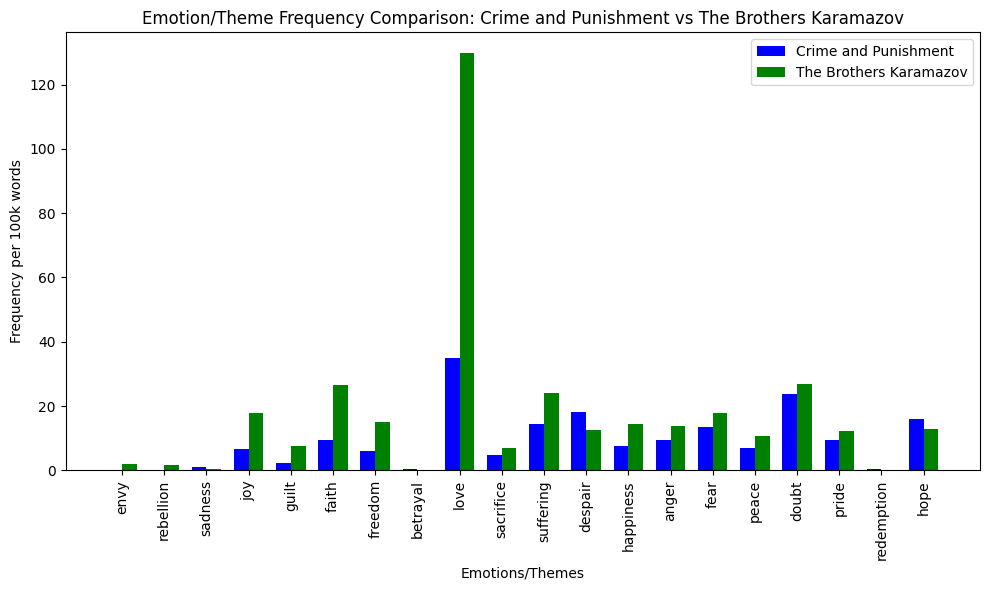

In [5]:
# Define emotion or theme-related words (replace with any themes you'd like to track)
EMOTION_LIST = {
    'joy', 'anger', 'sadness', 'guilt', 'love', 'fear', 'happiness', 'suffering', 'hope', 'despair',
    'redemption', 'envy', 'pride', 'peace', 'betrayal', 'sacrifice', 'freedom', 'doubt', 'faith', 'rebellion'
}



# Count emotion or theme words
def count_emotions(tokens, emotion_list=EMOTION_LIST):
    c = Counter(w for w in tokens if w in emotion_list)
    return c, sum(c.values()), len(tokens)

# Count emotions for Crime and Punishment and The Brothers Karamazov
a_emotions, a_hits, a_total = count_emotions(crime_words)
g_emotions, g_hits, g_total = count_emotions(brothers_words)

# Print top emotions and rate per 100k
print("Crime and Punishment top emotions:", a_emotions.most_common(15), "| rate per 100k:", (a_hits/a_total)*100000)
print("The Brothers Karamazov top emotions:", g_emotions.most_common(15), "| rate per 100k:", (g_hits/g_total)*100000)

# Normalize emotion counts per 100k words
a_emotions_normalized = {emotion: (count / a_total) * 100000 for emotion, count in a_emotions.items()}
g_emotions_normalized = {emotion: (count / g_total) * 100000 for emotion, count in g_emotions.items()}

# Combine both emotion counts into one dictionary (union of all emotions in both texts)
all_emotions = set(a_emotions.keys()).union(g_emotions.keys())
a_emotions_normalized = {emotion: a_emotions_normalized.get(emotion, 0) for emotion in all_emotions}
g_emotions_normalized = {emotion: g_emotions_normalized.get(emotion, 0) for emotion in all_emotions}

# Plotting
plt.figure(figsize=(10, 6))

# Bar plot for both Crime and Punishment and The Brothers Karamazov
bar_width = 0.35
index = range(len(all_emotions))

plt.bar(index, list(a_emotions_normalized.values()), bar_width, label="Crime and Punishment", color='blue')
plt.bar([i + bar_width for i in index], list(g_emotions_normalized.values()), bar_width, label="The Brothers Karamazov", color='green')

plt.xlabel('Emotions/Themes')
plt.ylabel('Frequency per 100k words')
plt.title('Emotion/Theme Frequency Comparison: Crime and Punishment vs The Brothers Karamazov')
plt.xticks([i + bar_width / 2 for i in index], list(all_emotions), rotation=90)
plt.legend()

plt.tight_layout()
plt.show()


Crime top: [('red', 37), ('white', 35), ('black', 33), ('yellow', 25), ('silver', 19), ('gold', 18), ('green', 17), ('grey', 16), ('blue', 11), ('crimson', 9), ('brown', 5), ('pink', 2), ('gray', 1), ('purple', 1), ('lavender', 1)] | rate per 100k: 107.6933118257513
Brothers top: [('white', 44), ('black', 41), ('red', 33), ('blue', 26), ('gray', 23), ('gold', 18), ('crimson', 17), ('yellow', 15), ('green', 12), ('pink', 11), ('brown', 6), ('silver', 6), ('purple', 4), ('ivory', 1)] | rate per 100k: 71.55864188937089


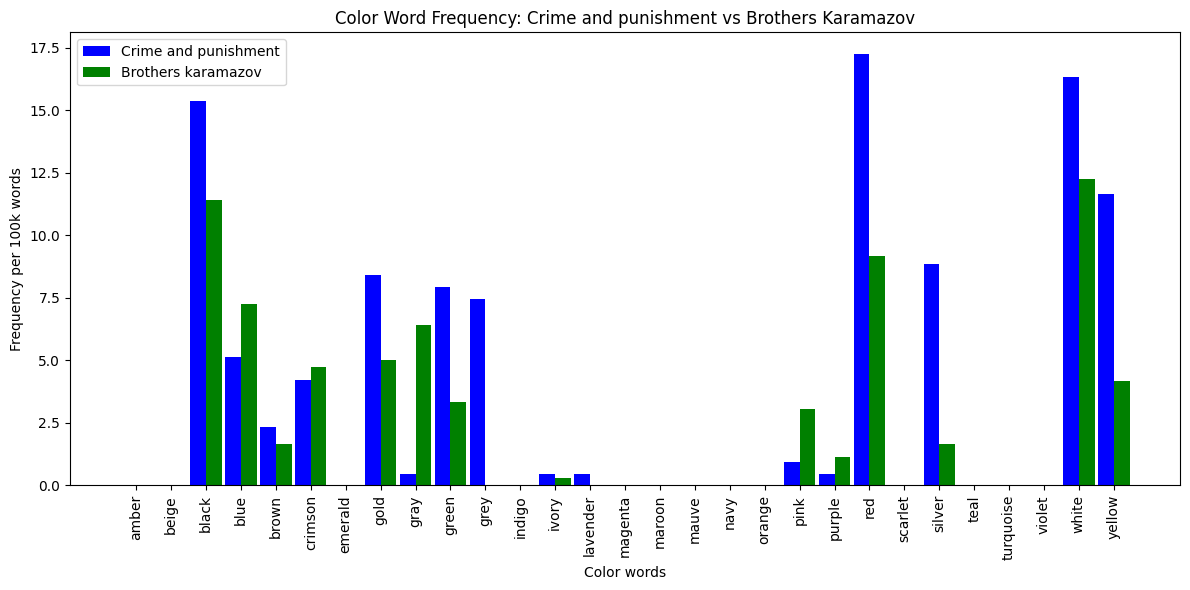

In [6]:
COLOR_LIST = {
    'red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'violet',
    'purple', 'pink', 'brown', 'black', 'white', 'gray', 'grey',
    'scarlet', 'crimson', 'emerald', 'amber', 'gold', 'silver',
    'lavender', 'mauve', 'ivory', 'beige', 'teal', 'turquoise',
    'magenta', 'maroon', 'navy'
}

def count_colors(tokens):
    c = Counter(w for w in tokens if w in COLOR_LIST)
    return c, sum(c.values()), len(tokens)

a_c, a_hits, a_total = count_colors(crime_words)
g_c, g_hits, g_total = count_colors(brothers_words)

print(
    "Crime top:", a_c.most_common(15),
    "| rate per 100k:", (a_hits / a_total) * 100000
)
print(
    "Brothers top:", g_c.most_common(15),
    "| rate per 100k:", (g_hits / g_total) * 100000
)


# Ensure COLOR_LIST exists (from your earlier code)
# COLOR_LIST = {...}

# Build a consistent x-axis order
all_colors = sorted(COLOR_LIST)

# Convert counts to rates per 100k words
a_rates = [(a_c.get(color, 0) / a_total) * 100000 for color in all_colors]
g_rates = [(g_c.get(color, 0) / g_total) * 100000 for color in all_colors]

# Plotting
plt.figure(figsize=(12, 6))

bar_width = 0.45
index = list(range(len(all_colors)))

plt.bar(index, a_rates, bar_width, label="Crime and punishment", color='blue')
plt.bar([i + bar_width for i in index], g_rates, bar_width, label="Brothers karamazov", color='green')

plt.xlabel('Color words')
plt.ylabel('Frequency per 100k words')
plt.title('Color Word Frequency: Crime and punishment vs Brothers Karamazov')
plt.xticks([i + bar_width / 2 for i in index], all_colors, rotation=90)
plt.legend()

plt.tight_layout()
plt.show()


**Discuss:** Where do color bursts cluster in the narrative? What scenes rely on color to signal mood or magic?

In [7]:
def rolling_emotion_windows(tokens, window=800, step=200, emotion_list=EMOTION_LIST):
    hits_per_window = []
    for i in range(0, max(1, len(tokens)-window+1), step):
        chunk = tokens[i:i+window]
        c = sum(1 for w in chunk if w in emotion_list)  # count the emotions/themes in the window
        hits_per_window.append((i, i+window, c, c * (100000/window)))  # per 100k
    return hits_per_window

# Nearest sentence span (for previewing emotional/thematic bursts)
def nearest_sentence_span(tokens, sents, start_idx, end_idx):
    text = " ".join(tokens[start_idx:end_idx])
    head = " ".join(tokens[start_idx:start_idx+20])
    for k, s in enumerate(sents):
        if head[:50] in s:
            j0 = max(0, k-1); j1 = min(len(sents), k+3)
            return j0, j1, " ".join(sents[j0:j1])
    return None, None, text[:500]

# Run emotion/theme analysis for both Crime and Punishment and The Brothers Karamazov
w_roll = rolling_emotion_windows(crime_words, window=800, step=200)
g_roll = rolling_emotion_windows(brothers_words, window=800, step=200)

# Top 5 bursts by per-100k
w_top = sorted(w_roll, key=lambda x: x[3], reverse=True)[:5]
g_top = sorted(g_roll, key=lambda x: x[3], reverse=True)[:5]

# Print emotional/theme bursts for both books
print("=== Crime and Punishment emotion bursts ===")
for a, b, h, rate in w_top:
    j0, j1, preview = nearest_sentence_span(crime_words, crime_sentences, a, b)
    print(f"[tokens {a}-{b}] hits={h} | {rate:.0f} per 100k")
    print(preview[:400], "…\n")

print("=== The Brothers Karamazov emotion bursts ===")
for a, b, h, rate in g_top:
    j0, j1, preview = nearest_sentence_span(brothers_words, brothers_sentences, a, b)
    print(f"[tokens {a}-{b}] hits={h} | {rate:.0f} per 100k")
    print(preview[:400], "…\n")

=== Crime and Punishment emotion bursts ===
[tokens 600-1400] hits=8 | 1000 per 100k
to a condition closely resembling slavery to the nobles whom the russian tsars had empow ered and although alexander ii abolished serfdom conditions remained virtually the same the lower classes pushing for freedom in an increasingly indus trialized society were headed toward revolution simultaneously traditional religious social and cul tural ideals were being overturned thinkers like karl marx a …

[tokens 20000-20800] hits=8 | 1000 per 100k
dostoevsky course but she will have to live with the man why she d live on black bread and water she would not sell her soul she would not barter her moral freedom for comfort she would not barter it for all schleswig holstein much less mr luzhin s money no dounia was not that sort when i knew her and she is still the same of course yes there s no denying the svidriga lovs are a bitter pill it s a …

[tokens 213400-214200] hits=8 | 1000 per 100k
her hand with her